### Plot Signals

In [2]:
import pandas as pd
import numpy as np
import plotting_util
from math import ceil
from scipy.stats import kurtosis
from scipy.signal import find_peaks, peak_widths


df = pd.read_parquet("out/can_data.parquet")
subject_006 = df[(df['subject_id'] == '006') & (df['subject_state'] == 'above') & (df['subject_scenario'] == 'town')]

def mean_peak_heights(x):
    _, props = find_peaks(x, height=0, width=1, plateau_size=0)
    return np.mean(props['peak_heights'])

def mean_peak_widths(x):
    ind, _ = find_peaks(x, height=0, width=1, plateau_size=0)
    widths, _, _, _ = peak_widths(x, ind)
    return np.mean(widths)


test = subject_006[subject_006['brake'] > 0].groupby((subject_006['brake'] == 0).cumsum(), as_index=False)
res = test.agg(
    {
        'timestamp': [lambda x: (x.max()-x.min()).total_seconds()],
        'brake': [mean_peak_heights, mean_peak_widths],
        'velocity': ['mean']
    }
    )
print(res)

   timestamp             brake                   velocity
    <lambda> mean_peak_heights mean_peak_widths      mean
0       2.80         43.270000        38.745262  7.460235
1       3.24         65.035000        34.824897  5.578878
2       7.00         36.020000       191.116550  0.000000
3       1.50         38.210000        19.519556  3.501957
4      15.13         76.330000       446.125938  0.016000
5       2.80         36.020000        30.179354  7.929059
6       4.57         28.985000        68.592925  0.892754
7       0.77          3.290000        17.070992  3.598750
8       1.20          0.830000        31.796258  2.882703
9       2.16         93.790000        31.237828  9.728182
10      0.67          0.940000        14.686275  2.847619
11      1.20          9.950000        24.805302  7.158108
12      1.76         62.500000        20.639056  2.488889
13      0.86         32.740000        17.043698  0.000000
14      2.40         21.260000        14.438852  6.681507
15      4.90  

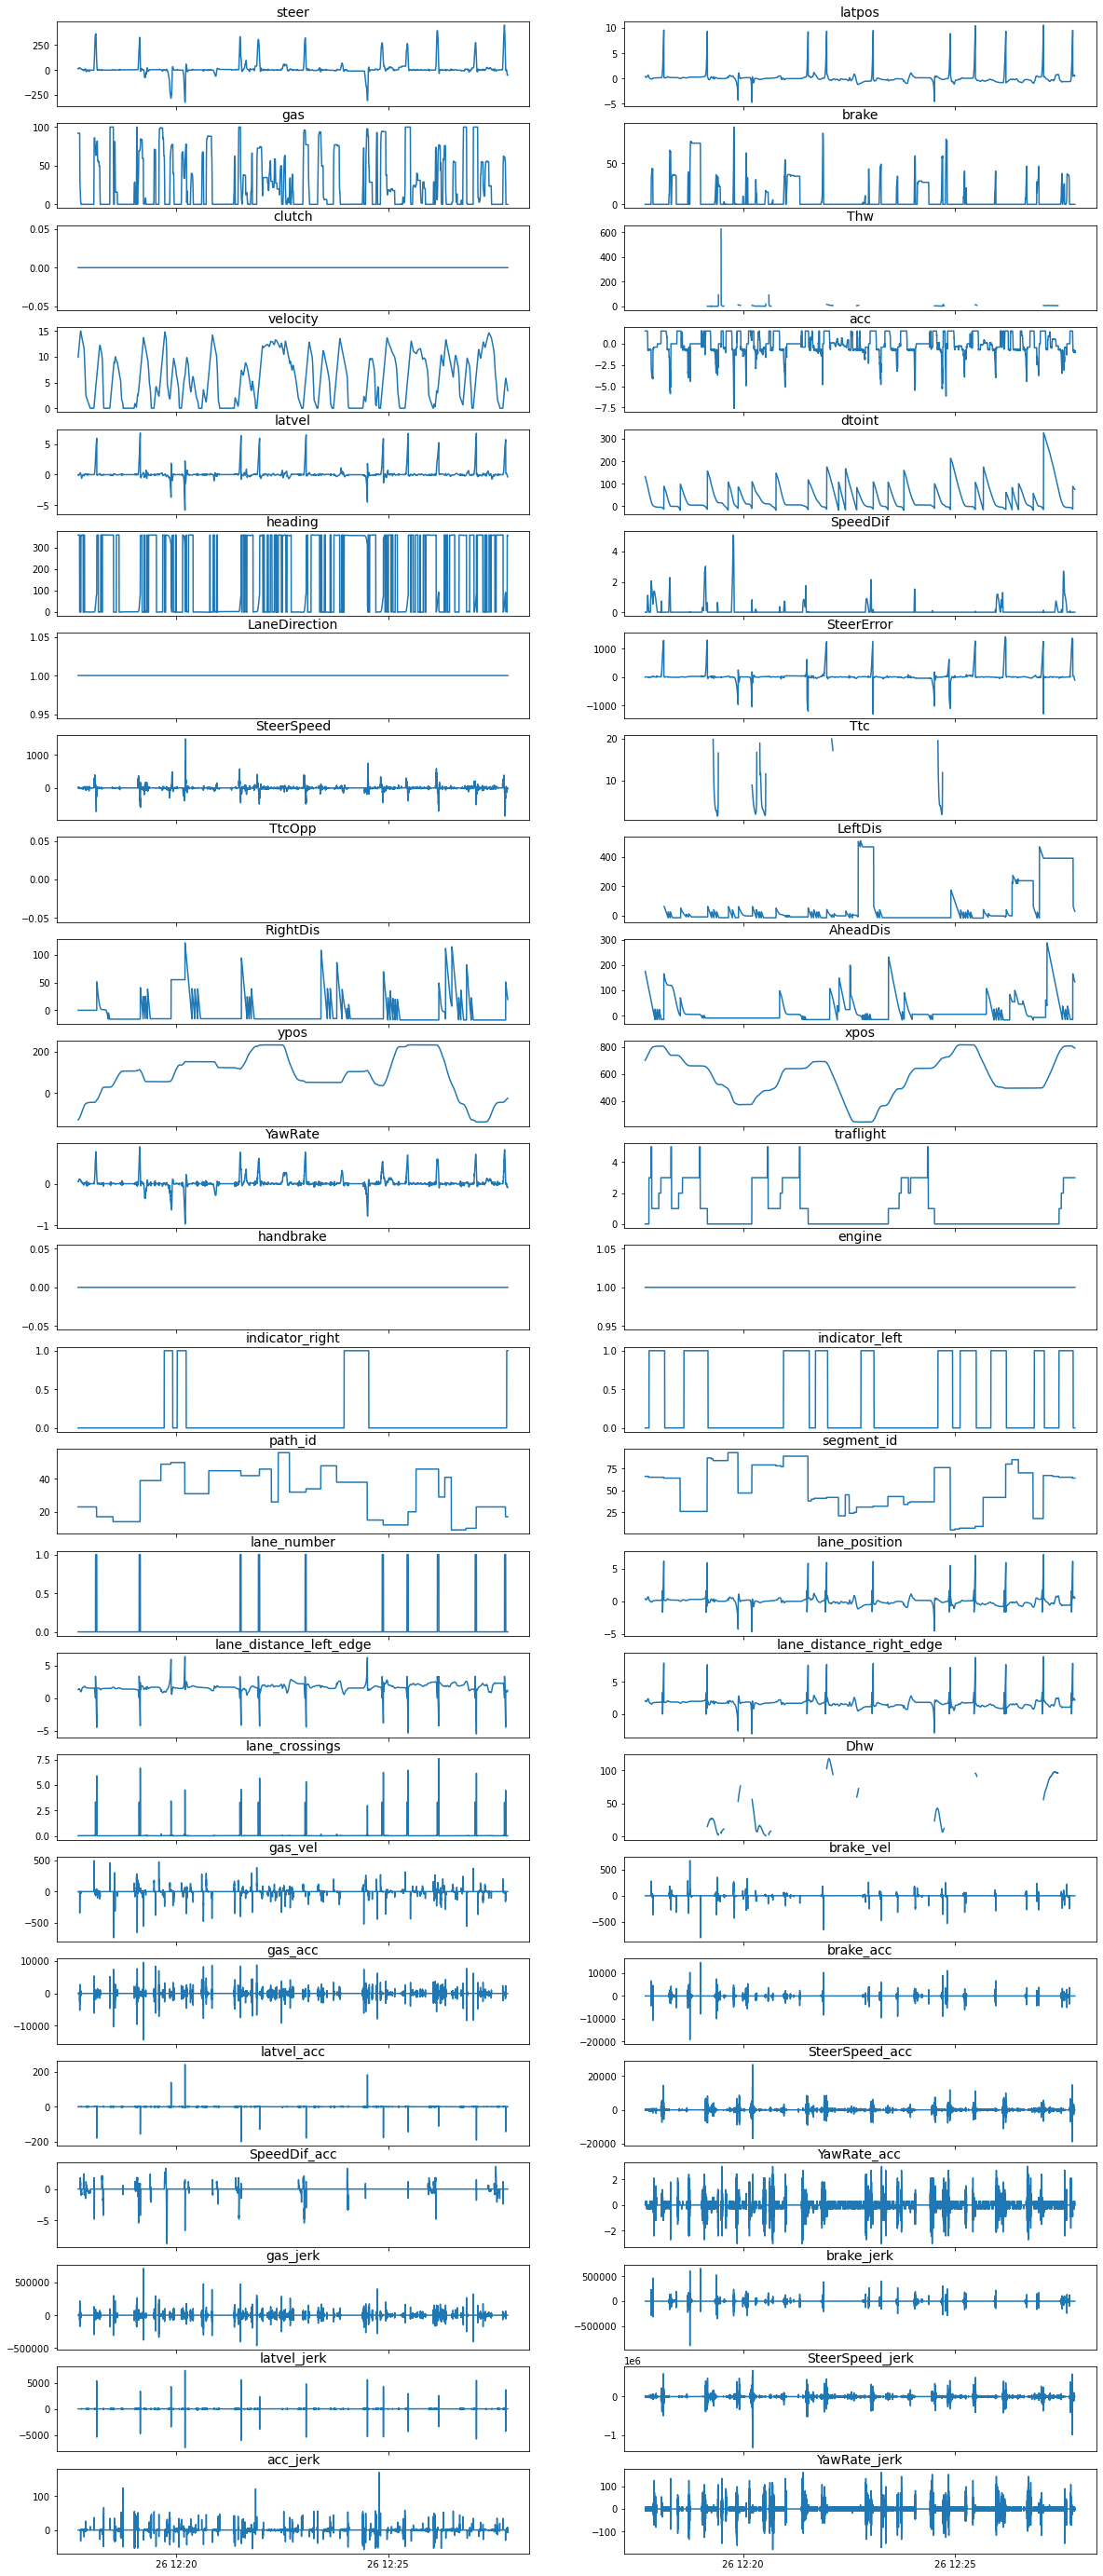

In [25]:
times = subject_006['timestamp']

nr_df_cols = len(subject_006.iloc[:, 5:].columns)
nr_rows = ceil(nr_df_cols / 2.0)
nr_cols = 2

fig, axes = plotting_util.create_plot(nr_rows, nr_cols, True, False)
for axs, row in zip(axes, list(range(nr_rows))):
    for ax, col in zip(axs, list(range(nr_cols))):
        plotting_util.set_plot_axis_labels(ax, '', '')
        plotting_util.set_plot_title(ax, subject_006.iloc[:, 4+2*row+col].name)
        ax.plot(times, subject_006.iloc[:, 4+2*row+col])
plotting_util.set_figure_size(fig, 20, 50)

### Plot Segment Positions

In [ ]:
import pandas as pd
import plotting_util
%matplotlib widget
lanes_df = pd.read_csv('out/scenario_information.csv')
lanes_df = lanes_df.loc[lanes_df['scenario'] == 'highway']
fig, ax = plotting_util.create_plot(1,1)
for _, row in lanes_df.iterrows():
    ax.plot([row['StartPos_x_segment'], row['EndPos_x_segment']], [row['StartPos_y_segment'], row['EndPos_y_segment']], 'o-')
plotting_util.set_figure_size(fig, 20, 20)

### ID Image Thresholding

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv

img = cv.imread('out/20210901_d-011_above/error_segment_1927394.0.jpg')
imhsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
mask = cv.inRange(imhsv, (0, 50, 0), (179, 255, 255))
img_no_artifacts = cv.bitwise_and(img, img, mask=mask)
imgray = cv.cvtColor(img_no_artifacts, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(imgray, 127, 255, cv.THRESH_BINARY)
plt.imshow(thresh)

### None Counting for Segment IDs

In [1]:
import pandas as pd
import glob
import re


DATA_FOLDER = '/adar/drive/study'

subject_folders = sorted(glob.glob(DATA_FOLDER + '/*_sober') + glob.glob(DATA_FOLDER + '/*_above') + glob.glob(
            DATA_FOLDER + '/*_below'))
subject_folders = [f for f in subject_folders if 'audio' not in f]

scenarios = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')

subject_re = re.compile('d-([0-9]+)')
for subject in subject_folders:
    subject_id_match = subject_re.search(subject)
    if not subject_id_match:
        continue
    subject_id = subject_id_match.group(1)

    if "drunk" in subject:
        state = "drunk"
    elif "above" in subject:
        state = "above"
    elif "below" in subject:
        state = "below"
    else:
        state = "sober"

    for scenario in scenarios: 
        can_data_for_subject = can_data.loc[(can_data['subject_id'] == subject_id) & (can_data['subject_state'] == state) & (can_data['subject_scenario'] == scenario)]
        print('subject_id: {}, state: {}, scenario: {}'.format(subject_id, state, scenario))
        print(can_data_for_subject['segment_id'].isna().sum())

subject_id: 006, state: above, scenario: highway
0
subject_id: 006, state: above, scenario: rural
0
subject_id: 006, state: above, scenario: town
0
subject_id: 006, state: below, scenario: highway
224
subject_id: 006, state: below, scenario: rural
0
subject_id: 006, state: below, scenario: town
0
subject_id: 006, state: sober, scenario: highway
4
subject_id: 006, state: sober, scenario: rural
0
subject_id: 006, state: sober, scenario: town
0
subject_id: 001, state: above, scenario: highway
0
subject_id: 001, state: above, scenario: rural
675
subject_id: 001, state: above, scenario: town
0
subject_id: 001, state: below, scenario: highway
153
subject_id: 001, state: below, scenario: rural
0
subject_id: 001, state: below, scenario: town
0
subject_id: 001, state: sober, scenario: highway
5
subject_id: 001, state: sober, scenario: rural
0
subject_id: 001, state: sober, scenario: town
0
subject_id: 011, state: above, scenario: highway
74
subject_id: 011, state: above, scenario: rural
0
subje

### Lane Position Validation

In [5]:
import pandas as pd
import glob
import re
import cv2 as cv
import random
import datetime
import pytz
import os

DATA_FOLDER = '/adar/drive/study'

subject_folders = sorted(glob.glob(DATA_FOLDER + '/*_sober') + glob.glob(DATA_FOLDER + '/*_above') + glob.glob(
            DATA_FOLDER + '/*_below'))
subject_folders = [f for f in subject_folders if 'audio' not in f]

selected_folders = random.sample(subject_folders, 5)
scenarios = ['highway', 'rural', 'town']

can_data = pd.read_parquet('out/can_data.parquet')

subject_re = re.compile('d-([0-9]+)')
timestamp_re = re.compile(r'(\d{4})-(\d{2})-(\d{2})--(\d{2})-(\d{2})-(\d{2}).flv')
for subject in selected_folders:
    subject_id_match = subject_re.search(subject)
    if not subject_id_match:
        continue
    subject_id = subject_id_match.group(1)

    if "drunk" in subject:
        state = "drunk"
    elif "above" in subject:
        state = "above"
    elif "below" in subject:
        state = "below"
    else:
        state = "sober"

    scenario = random.choice(scenarios)
    can_data_for_subject = can_data.loc[(can_data['subject_id'] == subject_id) & (can_data['subject_state'] == state) & (can_data['subject_scenario'] == scenario)]

    print('subject folder: {}, subject_id: {}, state: {}, scenario: {}'.format(subject, subject_id, state, scenario))
    
    for video in glob.glob(subject + '/obs-videos/*[!_cropped].flv'):
        print('video: {}'.format(video.split('/')[-1]))
        match = timestamp_re.search(video.split('/')[-1])
        if match:
            year = int(match.group(1))
            month = int(match.group(2))
            day = int(match.group(3))
            hour = int(match.group(4))
            minute = int(match.group(5))
            second = int(match.group(6))
            video_timestamp = datetime.datetime(year, month, day, hour, minute, second)
            tz = pytz.timezone('Europe/Zurich')
            video_timestamp = tz.localize(video_timestamp)
            can_data_lane = can_data_for_subject[['timestamp', 'latpos', 'segment_id', 'lane_number', 'lane_position', 'lane_distance_left_edge', 'lane_distance_right_edge']].copy()
            can_data_lane.loc[:, 'timestamp'] = (can_data_lane['timestamp'] - video_timestamp) / datetime.timedelta(milliseconds=1)
            sampled_values = can_data_lane.sample(10).sort_values(by='timestamp').to_numpy()
            cap = cv.VideoCapture(video)
            index = 0
            for timestamp_ms, latpos, segment_id, lane_nr, lane_pos, distance_left_edge, distance_right_edge in sampled_values:
                folder = 'out/' + subject.split('/')[-1]
                if not os.path.exists(folder):
                    os.makedirs(folder)
                is_set = cap.set(cv.CAP_PROP_POS_MSEC, timestamp_ms)
                if is_set:
                    success, frame = cap.read()
                    if success:
                        print('success')
                        img = cv.putText(frame, 'latpos: {}'.format(latpos), (1300, 1200), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(frame, 'segment id: {}'.format(segment_id), (1300, 1300), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane nr: {}'.format(lane_nr), (1300, 1400), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'lane pos: {}'.format(lane_pos), (1300, 1500), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'distance left edge: {}'.format(distance_left_edge), (1300, 1600), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        img = cv.putText(img, 'distance right edge: {}'.format(distance_right_edge), (1300, 1700), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255))
                        cv.imwrite(folder + '/img{}-{}-{}.png'.format(index, scenario, timestamp_ms / 1000.0), img)
                        index += 1
                    else:
                        print('could not get frame')
                else:
                    print('could not set video timestamp')

subject folder: /adar/drive/study/20211029_d-024_below, subject_id: 024, state: below, scenario: highway
video: 2021-10-29--15-06-08.flv
success
success
success
success
success
success
success
success
success
success
